In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix

# 0. Load datasets

In [2]:
datasets_path = lambda  file_name: f'/Users/stijnvanleeuwen/Desktop/codes/EUR/Ass2/datasets/{file_name}.parquet'

baskets = pd.read_parquet(datasets_path('baskets')).astype({'week':'uint8', 'customer':'category','product':'category', 'price':'uint16'}) 
coupons = pd.read_parquet(datasets_path('coupons')).astype({'week':'uint8', 'customer':'category','product':'category', 'discount':'uint8'})
prediction_index = pd.read_parquet(datasets_path('prediction_index')).astype({'week':'uint8', 'customer':'category','product':'category'}) 

# 1. Create base dataframe 

## a. Initiating

In [ ]:
weeks = range(0,88+1)
customers = range(1000,2000)
products = range(250)

n_weeks, n_customers, n_products = len(weeks), len(customers), len(products)

base = pd.DataFrame()

base['week'] =     np.array([[x] * n_products * n_customers for x in weeks]).flatten()
base['customer'] = np.array([[x] * n_products * n_weeks for x in customers]).flatten()
base['product'] =  np.array([[x] * n_weeks * n_customers for x in products]).flatten()

## b. From baskets [REVIEW ERROR]

In [53]:
base = pd.merge(base, baskets, on=['week', 'customer','product'], how='left')
base['price'] = base['price'].fillna(0).astype('uint16')
base['bought'] = (base['price']!=0).astype(int)

## c. From Coupons

In [56]:
coupons[coupons['customer']==0]

,week,customer,product,discount
0,0,0,35,35
1,0,0,193,40
2,0,0,27,30
3,0,0,177,35
4,0,0,5,30
...,...,...,...,...
44500000,89,0,131,30
44500001,89,0,16,25
44500002,89,0,91,25
44500003,89,0,222,10


In [77]:
hi = []
for i in range(250):
    ok = len(base[base['price']!=0][base[base['price']!=0]['product']==3]['price'].unique())
    hi.append(ok)

In [86]:
one = baskets[baskets['week']==1]
two = one[one['customer']==1803]
two

,week,customer,product,price
778600,1,1803,3,722
778601,1,1803,15,620
778602,1,1803,105,403
778603,1,1803,149,623
778604,1,1803,182,656
778605,1,1803,206,429


In [88]:
base[base['price']!=0].head(10)

,week,customer,product,price,bought
66750,1,1803,3,722,1
66751,1,1803,3,722,1
66752,1,1803,3,722,1
66753,1,1803,3,722,1
66754,1,1803,3,722,1
66755,1,1803,3,722,1
66756,1,1803,3,722,1
66757,1,1803,3,722,1
66758,1,1803,3,722,1
66759,1,1803,3,722,1


## d. Feature engineiring

# 2. Split into train & test

In [43]:
base

,week,customer,product,price,bought
0,0,1800,0,0,0
1,0,1800,0,0,0
2,0,1800,0,0,0
3,0,1800,0,0,0
4,0,1800,0,0,0
...,...,...,...,...,...
4449995,88,1999,249,0,0
4449996,88,1999,249,0,0
4449997,88,1999,249,0,0
4449998,88,1999,249,0,0


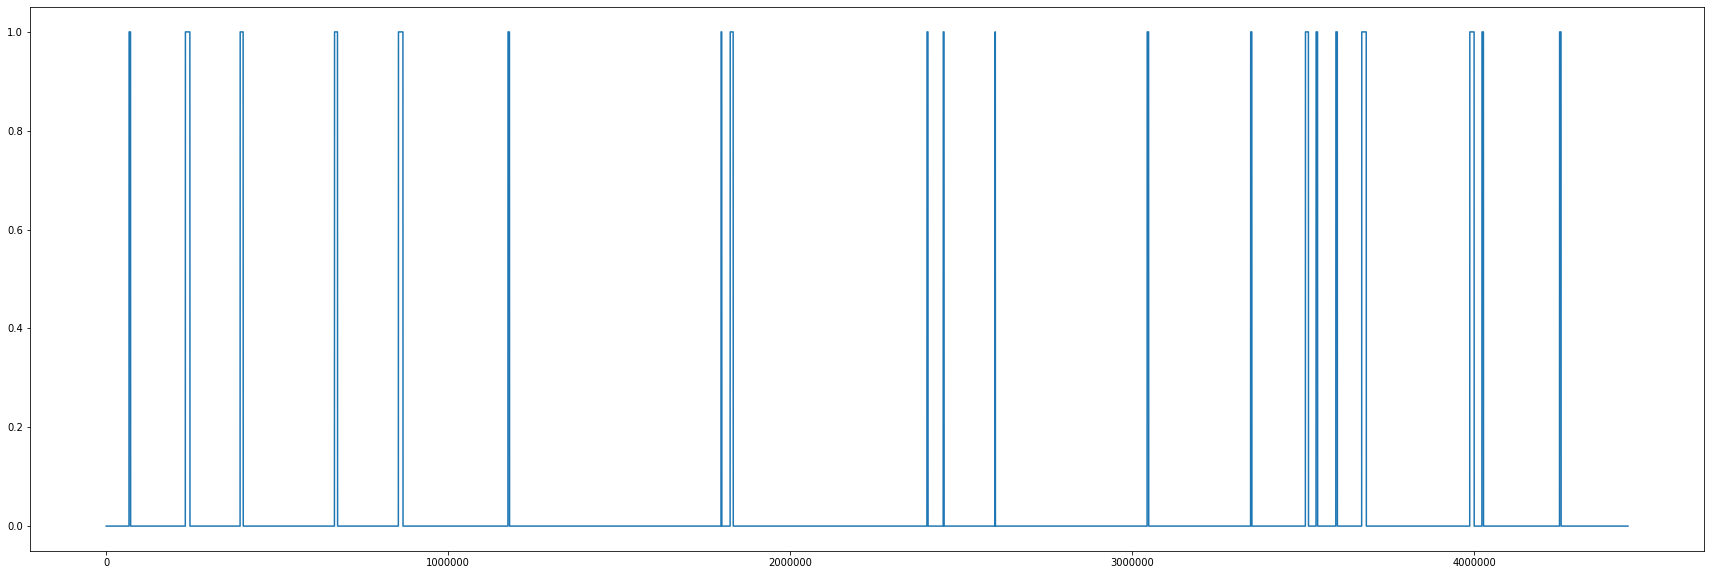

In [44]:
base['bought'].plot(figsize=(30,10))

In [52]:
train = base[base['week']!=88]
test =  base[base['week']==88]

x_train, x_test = train.drop(['price','bought'],axis=1), test.drop(['price','bought'],axis=1)
y_train, y_test = train['bought'], test['bought']
y_test.max()

0

# 3. Random Forest Classification

In [21]:
# a. Train model
model = DecisionTreeClassifier(max_leaf_nodes=1000)
model.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=1000)

<IPython.core.display.Javascript object>

[Text(4452.942073170731, 3187.4727272727273, 'customer <= 1828.5\ngini = 0.062\nsamples = 22000000\nvalue = [21290500, 709500]'),
 Text(3870.2743902439024, 3039.2181818181816, 'customer <= 1827.5\ngini = 0.071\nsamples = 18445250\nvalue = [17767250, 678000]'),
 Text(3734.1768292682927, 2890.9636363636364, 'customer <= 1806.5\ngini = 0.069\nsamples = 18423000\nvalue = [17767250, 655750]'),
 Text(3113.231707317073, 2742.7090909090907, 'customer <= 1429.5\ngini = 0.063\nsamples = 17955750\nvalue = [17366750, 589000]'),
 Text(2279.6341463414633, 2594.4545454545455, 'customer <= 1420.5\ngini = 0.081\nsamples = 9567500\nvalue = [9164750, 402750]'),
 Text(1633.170731707317, 2446.2, 'customer <= 1406.5\ngini = 0.06\nsamples = 9367250\nvalue = [9075750, 291500]'),
 Text(1156.8292682926829, 2297.9454545454546, 'customer <= 1008.5\ngini = 0.053\nsamples = 9055750\nvalue = [8808750, 247000]'),
 Text(884.6341463414634, 2149.690909090909, 'customer <= 1007.5\ngini = 0.198\nsamples = 200250\nvalue = 

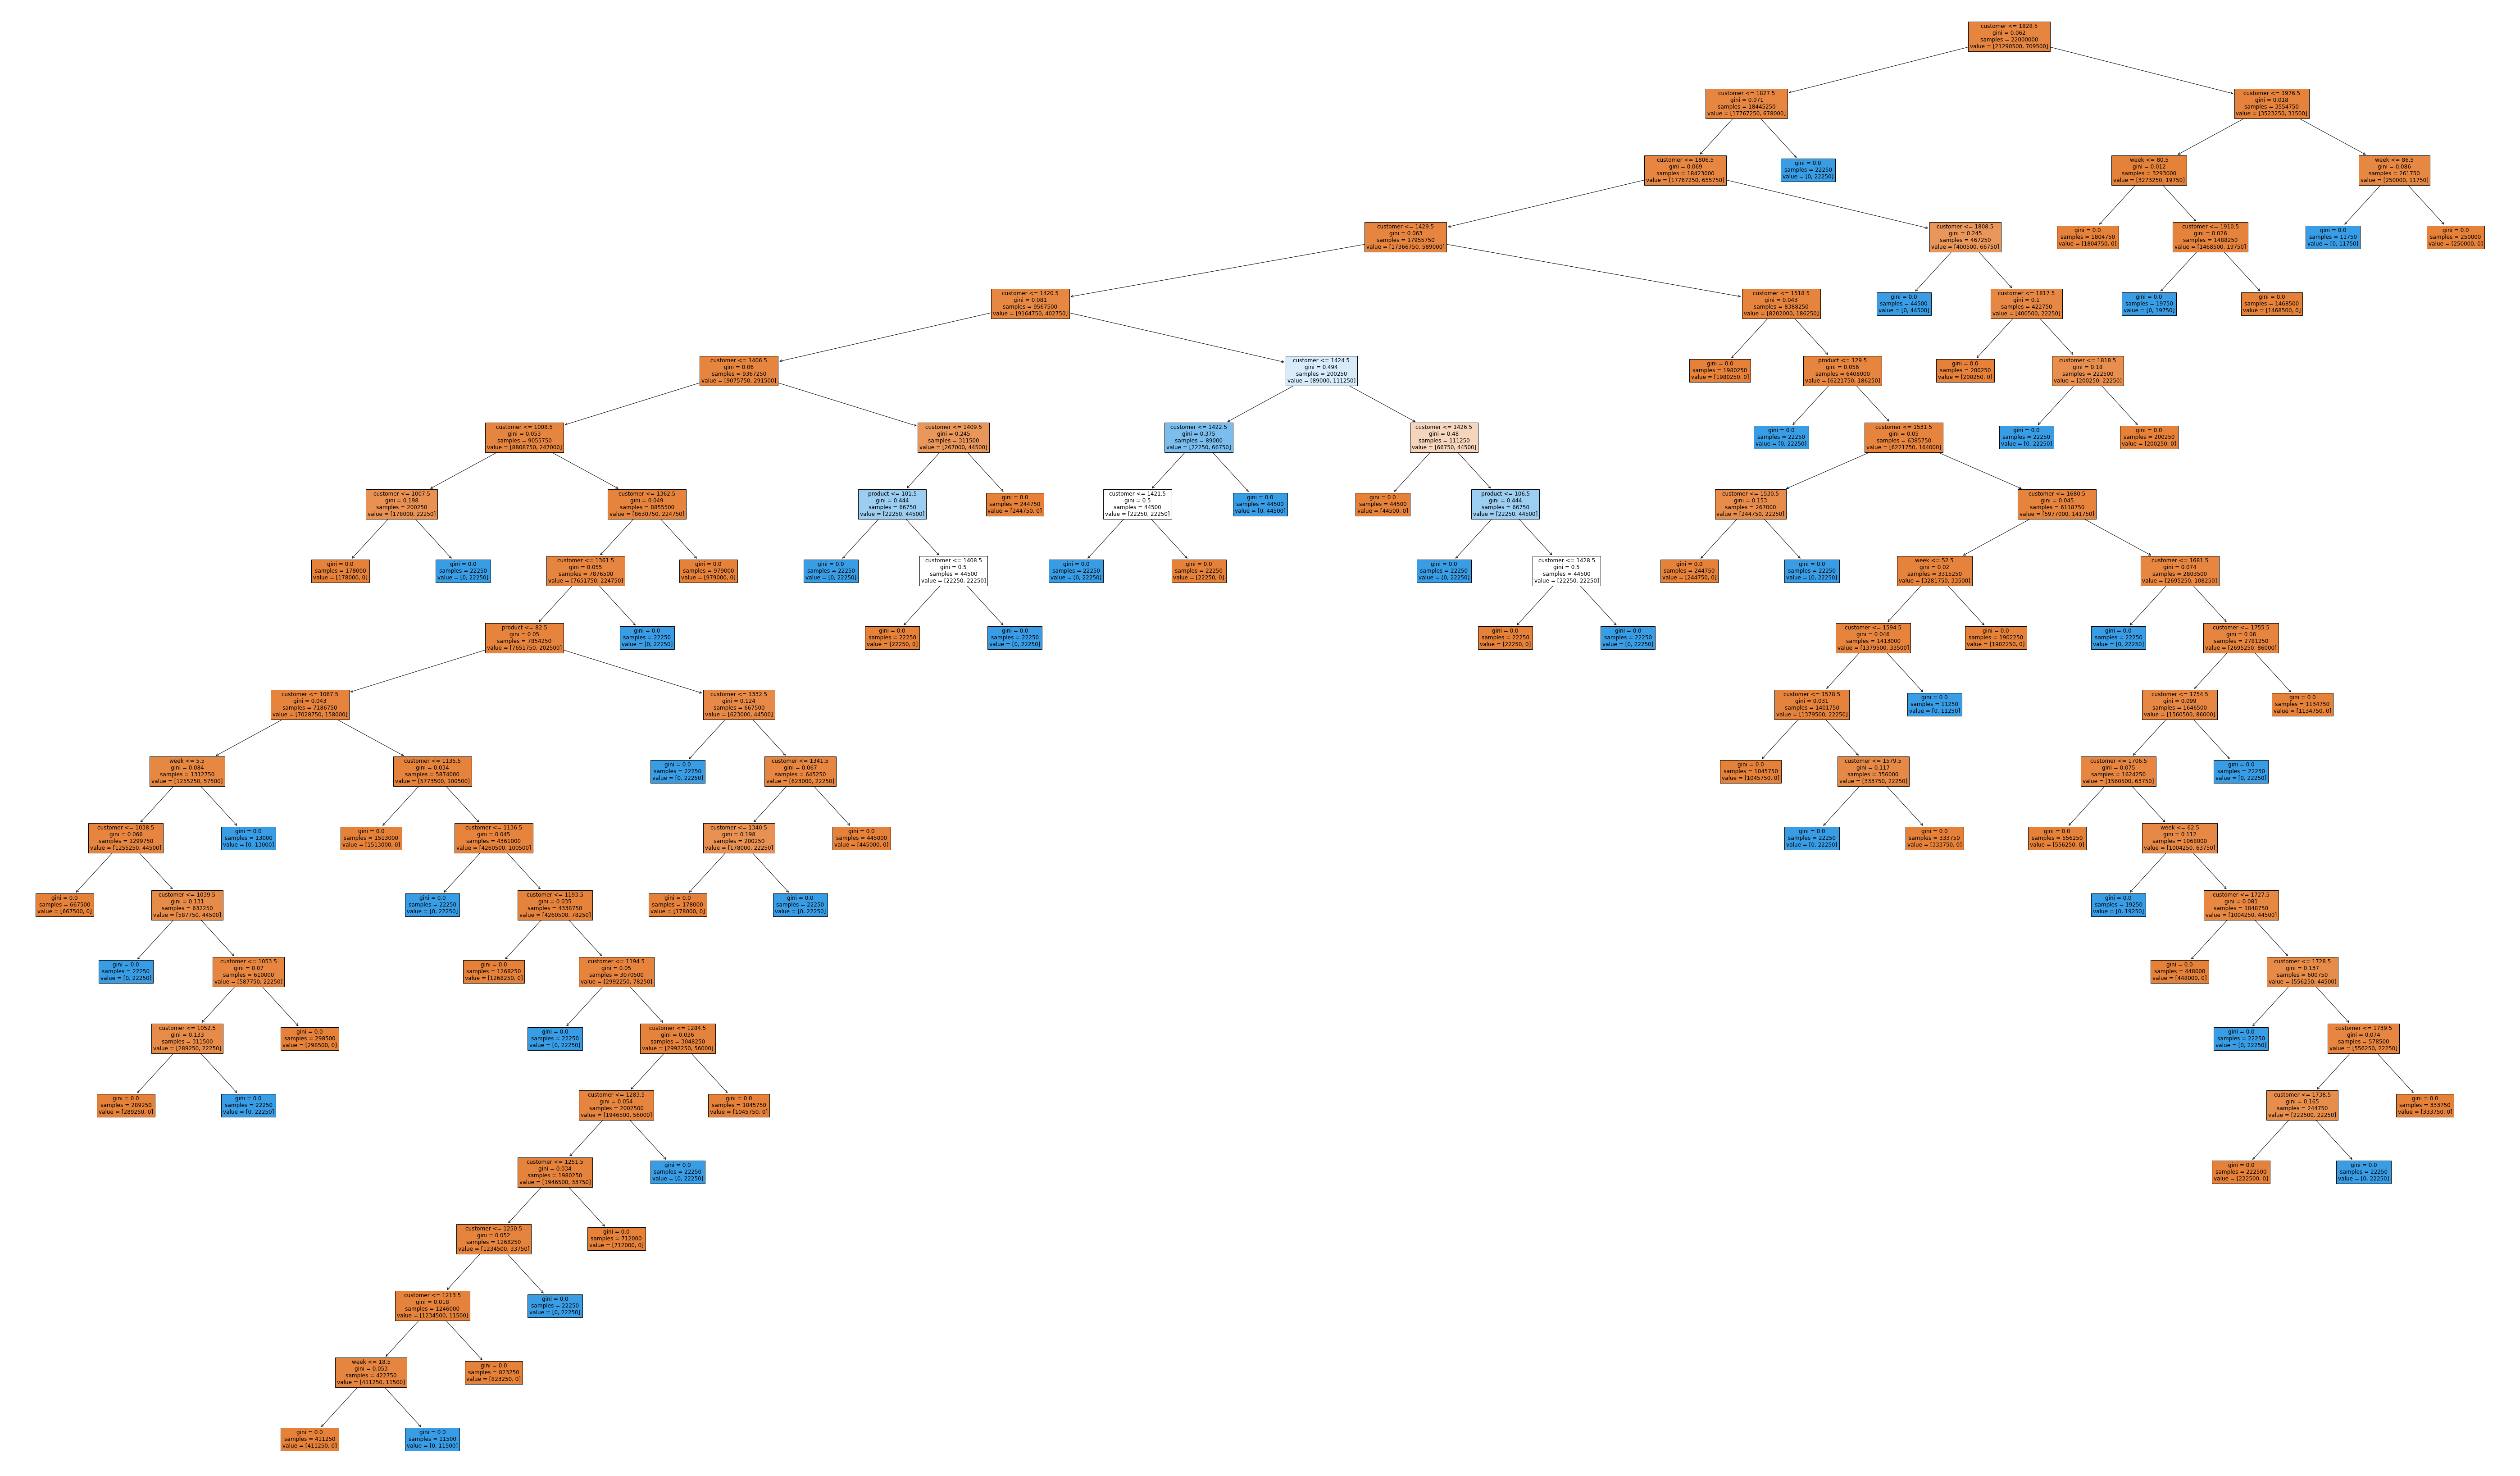

In [22]:
plt.figure(figsize=(100,60))
tree.plot_tree(model,fontsize=12, filled=1, feature_names=list(x_train.columns))

In [28]:
# b. Predict y on test
y_pred = model.predict(x_test)
y_pred.max()

0

In [17]:
# c. Get confusion matrix
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    227750
           1       0.00      0.00      0.00     22250

    accuracy                           0.91    250000
   macro avg       0.46      0.50      0.48    250000
weighted avg       0.83      0.91      0.87    250000



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
y_test.mean()

0.089

In [13]:
metrics.precision_score(y_test,y_pred)

NameError: name 'metrics' is not defined